TensorFlow is already loaded. Please restart the runtime to change versions.
11493376/11490434 [==============================] - 1s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 120us/step - loss: 0.2476 - val_loss: 0.1849
Epoch 2/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.1730 - val_loss: 0.1628
Epoch 3/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.1590 - val_loss: 0.1531
Epoch 4/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.1513 - val_loss: 0.1470
Epoch 5/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.1463 - val_loss: 0.1429
Epoch 6/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.1426 - val_loss: 0.1402
Epoch 7/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.1397 - val_loss: 0.1375
Epoch 8/20
60000/60000 [==============================] - 6s 108us

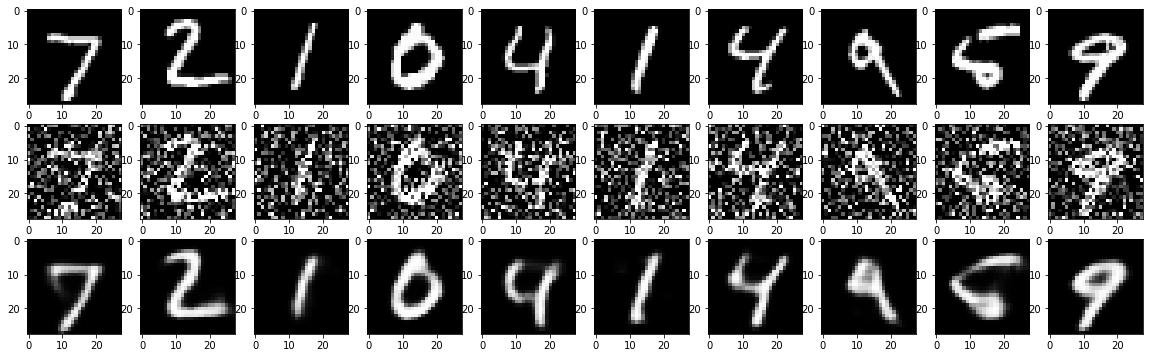

In [2]:
# 使用1.x版本的tensorflow
%tensorflow_version 1.x

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))   
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))   

#加入雜訊
noise_factor = 0.5
# numpy.random.normal 函數裡的三個參數分别代表生成的高斯分布的均值、標準差以及輸出的 size
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)  
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)  
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#autoencoder模型建立
input_img = Input(shape=(28, 28, 1))   
    
#encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) 
x = MaxPooling2D((2, 2), padding='same', name='encoder')(x)   
#Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# 用 Model 來搭建模型，輸入為圖片，輸出是解碼的結果
autoencoder = Model(input_img, x)  
    
# 編譯模型，optimizer 使用 adam，loss 使用 binary_crossentropy
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 訓練 Autoencoder ，輸入是加入雜訊的圖片，輸出是原始圖片
autoencoder.fit(x_train_noisy, x_train,
                    epochs=20,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))

#將有雜訊的測試影像丟入訓練好的模型進行訓練
denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))

#繪製圖形
plt.figure(figsize=(20, 6))

for i in range(10):
    ax = plt.subplot(3, 10, i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax = plt.subplot(3, 10, i+11)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax = plt.subplot(3, 10, i+21)
    plt.imshow(denoised_images[i].reshape(28, 28))
    plt.gray()
plt.show()